# Purchase model using e-commerce data

### Import packages

In [261]:
# data processing
import numpy as np
import pandas as pd
from datetime import date

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Set-up

For this expercise, we will utilize two files (listed below) from the 'Brazilian E-Commerce Public Dataset' originally posted on [Kaggle]( https://www.kaggle.com/olistbr/brazilian-ecommerce).

In [262]:
# full path of the orders dataset
orders_file = '../data/olist_orders_dataset.csv'

# full path of the customer dataset
cust_file = '../data/olist_customers_dataset.csv'

##look at files to determine other attributes...
# cust_file_test = pd.read_csv('../data/olist_customers_dataset.csv')
# cust_file_test.head()

# orders_file_test = pd.read_csv('../data/olist_orders_dataset.csv')
# orders_file_test.head()

### Read data

In [461]:
def read_olist_data(file1, file2, use_cols, cutoff_dt, verbose):
    
    # read the orders data
    orders = pd.read_csv(file1)

    if verbose:
        print (f'{len(orders):,} read from the orders file.')

    # date-time conversion
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
    orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])


    # let's convert the order purchase timestamps into dates
    orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date
    orders['order_estimated_delivery_date'] = orders['order_estimated_delivery_date'].dt.date

    # extract month from the order date
    orders['order_dow'] = orders['order_purchase_timestamp'].dt.day_name()

    # read the file that contains the unique customer identifier
    # also, let's keep only the following two columns: customer_id, customer_unique_id
    cust = pd.read_csv(file2, usecols=['customer_id', 'customer_unique_id'])
    
    if verbose:
        print (f'{len(cust):,} read from the customer file.')

    # merge orders and cust dataframes
    orders_out = pd.merge(orders, cust, on='customer_id', how='inner')
    
    # discard (incomplete) data after cutoff_dt
    # we do this here by using a boolean (True/False) mask
    mask = orders_out['order_purchase_date'] <= cutoff_dt

    orders_out = orders_out[mask]
    
    # sort the output dataset by order date for each customer
    orders_out = orders_out[use_cols].sort_values(['customer_unique_id', 'order_purchase_timestamp'])

    if verbose:
        print (f'{len(orders_out):,} records in the output  file.')
    
    return orders_out

In [462]:
# we will keep only these columns for this exercise
use_cols = ['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'order_dow']

# we will discard (incomplete) data after 8/22/18 (see 06_pandas_wrangle.ipynb for the rationale)
cutoff_date = date(2018, 8, 22)

orders = read_olist_data(orders_file, cust_file, use_cols, cutoff_date, 1)

99,441 read from the orders file.
99,441 read from the customer file.
98,906 records in the output  file.


This is our combined raw dataset from which we will create attributes and label for each customer.

## Binary Classification Model: Data Preparation

Let's build a model to predict whether a customer will make a purchase within the next month.

We will use *July 2018*, which is the most recent complete month, as the prediction window. In other words, we will use all available data prior to July 2018 to predict which customers will make a purchase in July 2018.

In [463]:
snapshot_date = date(2017,12,31) #for assign3 change this to (2017, 12, 31) #latest observation window date

In [266]:
#df_raw[(df_raw['order_dow'] == 'Thursday')].iloc[0:2]

### MODIFY DF FOR ADDT'L ATTRIBUTES AC

In [486]:
#add 'order_status' to use_cols2

use_cols2 = ['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'order_estimated_delivery_date','order_status']

orders2 = read_olist_data(orders_file, cust_file, use_cols2, cutoff_date, 1)

99,441 read from the orders file.
99,441 read from the customer file.
98,906 records in the output  file.


In [487]:
mask = orders2['order_purchase_timestamp'].dt.date <= snapshot_date

df_raw2 = orders2[mask]

print(len(df_raw2), df_raw2.order_purchase_timestamp.min(),df_raw2.order_purchase_timestamp.max())

45430 2016-09-04 21:15:19 2017-12-31 23:29:31


### Attribute #5 AC: ESTIMATED DELIVERY TIME

In [488]:
# there are empty delivery dates for customers that didn't order. I think it would be important not to remove them...
# probably have to use estimated delivery date...make sense because that MAY be what caused them to cancel.

# 'order_estimated_delivery_date' Shows the ESTIMATED order delivery date to the customer.

df_raw2['order_estimated_delivery_date'] = pd.to_datetime(df_raw2['order_estimated_delivery_date'])

delta2 = df_raw2['order_estimated_delivery_date'].dt.date - df_raw2['order_purchase_timestamp'].dt.date


<ipython-input-488-a75360f86446>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw2['order_estimated_delivery_date'] = pd.to_datetime(df_raw2['order_estimated_delivery_date'])


26460   28 days
98493   32 days
41564   21 days
71235   33 days
26203   28 days
          ...  
23135   33 days
87007   55 days
20556   33 days
43943   45 days
70017   24 days
Length: 45430, dtype: timedelta64[ns]

In [489]:
# grab the number of days (as an integer) from the calculated deltas

df_raw2['est_delivery_days'] = delta2.dt.days

df_raw2.est_delivery_days = df_raw2.est_delivery_days.astype(int)

df_raw2.head()

<ipython-input-489-072ab6d90456>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw2['est_delivery_days'] = delta2.dt.days
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,customer_unique_id,order_id,order_purchase_timestamp,order_estimated_delivery_date,order_status,est_delivery_days
26460,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,2017-04-07,delivered,28
98493,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,2017-11-13,delivered,32
41564,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,2017-12-05,delivered,21
71235,0005e1862207bf6ccc02e4228effd9a0,ae76bef74b97bcb0b3e355e60d9a6f9c,2017-03-04 23:32:12,2017-04-06,delivered,33
26203,0006fdc98a402fceb4eb0ee528f6a8d4,6681163e3dab91c549952b2845b20281,2017-07-18 09:23:10,2017-08-15,delivered,28


In [491]:
# grab the max purchase date for each customer

est_delivery = df_raw2.groupby('customer_unique_id')['est_delivery_days'].mean().reset_index()

len(cust_recency)

44034

### Attribute #4 AC: Order Status

In [425]:
# dummies for order_status (approved, canceled, etc)

df_raw4 = pd.get_dummies(df_raw2, columns=['order_status'])

In [426]:
# grab all binary columns that we just created
dummies2 = [x for x in df_raw4.columns if 'order_status' in x]

# aggreagte data to the customer-level, so that we have one record per customer
cust_order_status = df_raw4.groupby('customer_unique_id')[dummies2].sum().reset_index()

cust_order_status.head()

,customer_unique_id,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable
0,0000f46a3911fa3c0805444483337064,0,0,0,1,0,0,0,0
1,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,1,0,0,0,0
2,0004aac84e0df4da2b147fca70cf8255,0,0,0,1,0,0,0,0
3,0005e1862207bf6ccc02e4228effd9a0,0,0,0,1,0,0,0,0
4,0006fdc98a402fceb4eb0ee528f6a8d4,0,0,0,1,0,0,0,0


In [430]:
#len(orders2), len(df_raw2), len(cust_order_status)
len(cust_order_status)

44034

### Attribute #1: Order recency

For creating model attributes (features) we will have to restrict our data to the timeframe prior to the prediction window.

In [390]:
mask = orders['order_purchase_timestamp'].dt.date <= snapshot_date

In [391]:
# apply the filter

df_raw = orders[mask]

len(orders), len(df_raw)

(98906, 45430)

In [269]:
# check the max date

print(df_raw.order_purchase_timestamp.min(),df_raw.order_purchase_timestamp.max())

2016-09-04 21:15:19 2017-12-31 23:29:31


To calculate recency (days since the most recent order), we will have to extract *the most recent date* for each customer.

In [270]:
# grab the max purchase date for each customer

cust_recency = df_raw.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()

cust_recency.head()

,customer_unique_id,order_purchase_timestamp
0,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
2,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42
3,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18 09:23:10


In [271]:
# count the number of days between the most recent order date and the snapshot date

delta = snapshot_date - cust_recency['order_purchase_timestamp'].dt.date

delta.head()

0   296 days
1    80 days
2    47 days
3   302 days
4   166 days
Name: order_purchase_timestamp, dtype: timedelta64[ns]

In [272]:
# grab the number of days (as an integer) from the calculated deltas IN MONTHS

cust_recency['order_recency'] = delta.dt.days /30
cust_recency['order_recency'] = cust_recency['order_recency'].astype(int)
cust_recency.head()

,customer_unique_id,order_purchase_timestamp,order_recency
0,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,9
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2
2,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1
3,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,10
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18 09:23:10,5


In [273]:
# drop the date (we don't need it any more for this exercise)

cust_recency = cust_recency.drop('order_purchase_timestamp', axis=1)

In [274]:
# how many records (unique customers) do we have for this timeframe?

len(cust_recency) #unique because customers are aggregated depsite orders

44034

This is the number of customers who are included in the modeling dasetset for this specific time-frame.

Let's check the distribution of this attribute.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


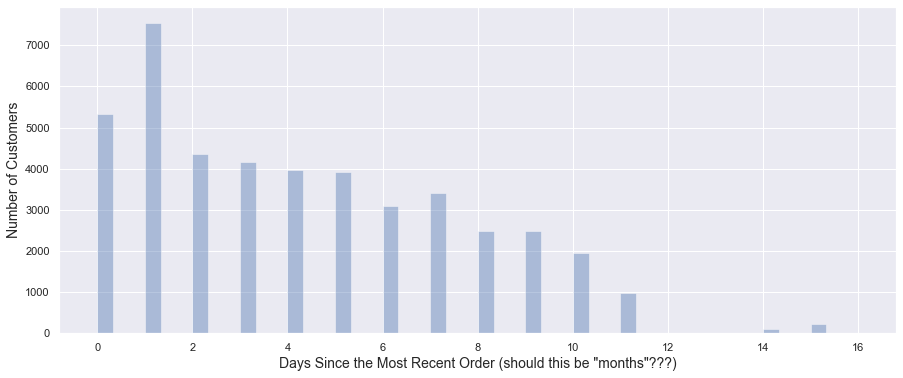

In [275]:
sns.set(style='darkgrid')

# adjust the plot size
plt.figure().set_size_inches(15, 6)

# histogram
sns.distplot(cust_recency['order_recency'], kde=False)

# assign axis labels
plt.ylabel('Number of Customers', fontsize=14)
plt.xlabel('Days Since the Most Recent Order (should this be "months"???)', fontsize=14);

In [276]:
cust_recency.head()

,customer_unique_id,order_recency
0,0000f46a3911fa3c0805444483337064,9
1,0000f6ccb0745a6a4b88665a16c9f078,2
2,0004aac84e0df4da2b147fca70cf8255,1
3,0005e1862207bf6ccc02e4228effd9a0,10
4,0006fdc98a402fceb4eb0ee528f6a8d4,5


Let's take a look at the cumulative distribution of customers by recency.

In [277]:
recency_distr = cust_recency.groupby('order_recency').size().reset_index()
    #'size()' seems to count the number of order_recency, vs 'count()' counting the number of customer_unique_d
    #size also "counts" NaN's

recency_distr = recency_distr.rename(columns={0: 'cust_count'})

recency_distr

,order_recency,cust_count
0,0,5336
1,1,7548
2,2,4354
3,3,4160
4,4,3972
5,5,3920
6,6,3103
7,7,3414
8,8,2480
9,9,2476


In [278]:
# calculate cumulative percentages 

cum_pctg = recency_distr['cust_count'].cumsum() / sum(recency_distr['cust_count'])

cum_pctg.head()

0    0.121179
1    0.292592
2    0.391470
3    0.485943
4    0.576146
Name: cust_count, dtype: float64

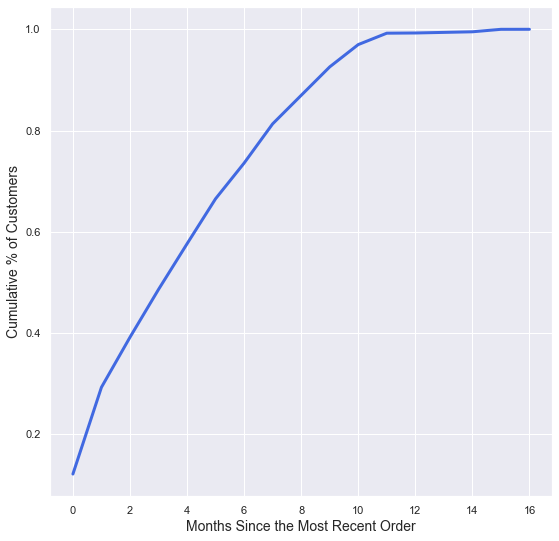

In [279]:
sns.set(style='darkgrid')

# adjust the plot size
plt.figure().set_size_inches(9, 9)

# histogram
sns.lineplot(x=recency_distr['order_recency'], y=cum_pctg, color='royalblue', lw=3)

# assign axis labels
plt.ylabel('Cumulative % of Customers', fontsize=14)
plt.xlabel('Months Since the Most Recent Order', fontsize=14);

Additional eligibility criteria can be applied to exclude customers (from the modeling dataset) who have not shopped in more than, e.g., one/two years.

### Attribute #2: Number of orders per customer

In [280]:
# count total records (i.e., orders) per customer

cust_orders = df_raw.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'total_orders'})

cust_orders.head()

,customer_unique_id,total_orders
0,0000f46a3911fa3c0805444483337064,1
1,0000f6ccb0745a6a4b88665a16c9f078,1
2,0004aac84e0df4da2b147fca70cf8255,1
3,0005e1862207bf6ccc02e4228effd9a0,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,1


In [281]:
cust_orders = df_raw.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'total_orders'})


In [282]:
order_count_totals = cust_orders.groupby('total_orders').size()

len(df_raw), len(cust_orders)

(45430, 44034)

In [283]:
order_count_totals

total_orders
1     42770
2      1164
3        80
4        14
5         4
6         1
10        1
dtype: int64

### Attribute set #3: Weekday

In [284]:
df_raw.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_dow
26460,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,Friday
98493,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,Thursday
41564,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,Tuesday
71235,0005e1862207bf6ccc02e4228effd9a0,ae76bef74b97bcb0b3e355e60d9a6f9c,2017-03-04 23:32:12,Saturday
26203,0006fdc98a402fceb4eb0ee528f6a8d4,6681163e3dab91c549952b2845b20281,2017-07-18 09:23:10,Tuesday


In [285]:
# get dummies

df_raw = pd.get_dummies(df_raw, columns=['order_dow'])

In [286]:
print(dummies)

['order_dow_Friday', 'order_dow_Monday', 'order_dow_Saturday', 'order_dow_Sunday', 'order_dow_Thursday', 'order_dow_Tuesday', 'order_dow_Wednesday']


In [287]:
# grab all binary columns that we just created
dummies = [x for x in df_raw.columns if 'order_dow' in x]

# aggreagte data to the customer-level, so that we have one record per customer
cust_dow = df_raw.groupby('customer_unique_id')[dummies].sum().reset_index()

cust_dow.head()

,customer_unique_id,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday
0,0000f46a3911fa3c0805444483337064,1,0,0,0,0,0,0
1,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,1,0,0
2,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,1,0
3,0005e1862207bf6ccc02e4228effd9a0,0,0,1,0,0,0,0
4,0006fdc98a402fceb4eb0ee528f6a8d4,0,0,0,0,0,1,0


### Combine all attributes into a single dataframe

In [289]:
# let's check the number of records in each dataframe first

cust_recency.shape, cust_orders.shape, cust_dow.shape


((44034, 2), (44034, 2), (44034, 8))

In [305]:
# combine (merge) `cust_recency` with `cust_orders` so that we have both attributes in one dataset

df = pd.merge(cust_recency, cust_orders, on='customer_unique_id').merge(cust_dow, on='customer_unique_id')

df.shape

(44034, 10)

In [306]:
df.head()

,customer_unique_id,order_recency,total_orders,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday
0,0000f46a3911fa3c0805444483337064,9,1,1,0,0,0,0,0,0
1,0000f6ccb0745a6a4b88665a16c9f078,2,1,0,0,0,0,1,0,0
2,0004aac84e0df4da2b147fca70cf8255,1,1,0,0,0,0,0,1,0
3,0005e1862207bf6ccc02e4228effd9a0,10,1,0,0,1,0,0,0,0
4,0006fdc98a402fceb4eb0ee528f6a8d4,5,1,0,0,0,0,0,1,0


Exclude customers who have not placed an order within the past one year.

In [307]:
df = df[df['order_recency'] <= 12]

len(df)

43713

### Assign labels (aka the target variable or the dependent variable)

For this exercise, we will assume that the objective of the model is to predict whether a customer will make *at least one purchase* in the future (i.e., within the target window of the model).

**Step 1:** Isolate all orders that were placed within the prediction window.

In [308]:
# select orders that were placed between jan 1 2018 & july 31 2018 (cutoff_date)

mask = (orders['order_purchase_timestamp'].dt.month >= 1) & \
        (orders['order_purchase_timestamp'].dt.month <= 7) & \
        (orders['order_purchase_timestamp'].dt.year == 2018)

target_events_raw = orders[mask] #masks ALL orders

len(target_events_raw)

47479

In [309]:
# confirm the min and max dates are between Jan and July 2018

print({target_events_raw['order_purchase_timestamp'].min()},{target_events_raw['order_purchase_timestamp'].max()})

{Timestamp('2018-01-01 02:48:41')} {Timestamp('2018-07-31 23:54:20')}


**Step 2:** Summarize data to get one record per customer.

In [376]:
# count the number of orders (we will convert this into a binary flag later) 
#NOT LOOKING AT how many purchases here...b/c this is the predictor group...

target_events = target_events_raw.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'purch'})

len(target_events)

46412

In [311]:
print(f'Number of customers who made at least one purchase during the prediction window: {len(target_events):,}')

Number of customers who made at least one purchase during the prediction window: 46,412


**Step 3:** Merge this dataframe with the `attr` dataframe to create the modeling dataset.

In [312]:
# merge `target_events` with the dataframe that contains customer attributes

df = pd.merge(df, target_events, how='left', on='customer_unique_id')

df.shape


(43713, 11)

We need to convert this variable into a binary flag.

**Step 4:** Set the target variable to 1 if at least one purchase was made, 0 otherwise.

In [348]:
# create the binary target flag 
# keep in mind these customers (622) mostly made purchases in the predicted window, results in 622

df['purch'] = [1 if x > 0 else 0 for x in df['purch']]

df.purch.value_counts()

0    43091
1      622
Name: purch, dtype: int64

In [346]:
print(f'''# of customers that made purchase at least 1 purchase in the predicted window is 
{df.purch.value_counts()[1]:,} for the snapshot window''')

# of customers that made purchase at least 1 purchase in the predicted window is 
622 for the snapshot window


In [347]:
# % distribution of the target flag

df.purch.value_counts() / len(df)

0    0.985771
1    0.014229
Name: purch, dtype: float64

There are two issues here: (1) the target event is extremely rare, and (2) the number of target events is also extremely small. There are several ways to circumvent these issues, but for now we will proceed with this dataset. 

In [349]:
# check the correlations

df.corr()['purch']

order_recency         -0.013936
total_orders           0.070029
order_dow_Friday      -0.000731
order_dow_Monday       0.012103
order_dow_Saturday    -0.003484
order_dow_Sunday       0.012515
order_dow_Thursday     0.003865
order_dow_Tuesday      0.007170
order_dow_Wednesday    0.006607
purch                  1.000000
Name: purch, dtype: float64

Before moving on to model building, let create a two-axis plot to view the purchase rates by recency.

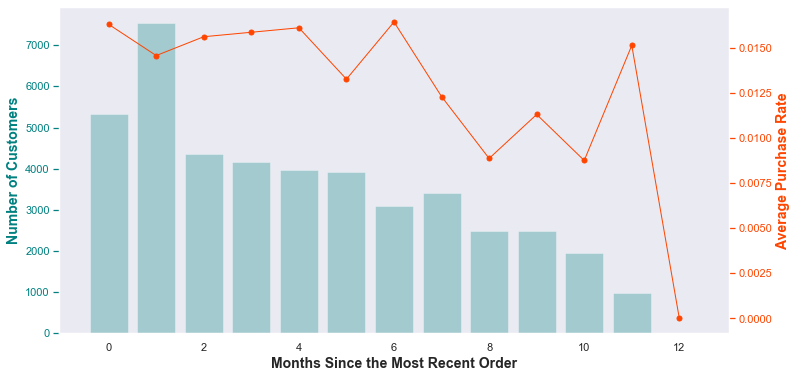

In [323]:
purch_rate_by_recency = df.groupby('order_recency')['purch'].mean().reset_index()

purch_rate_by_recency['orders'] = df.groupby('order_recency').size().reset_index()[0]

sns.set(style = 'dark')
f, ax = plt.subplots(figsize = (12, 6))

# create a secondary axis
ax2 = ax.twinx()

#bar chart for number of orders

ax.bar(purch_rate_by_recency['order_recency'], purch_rate_by_recency['orders'], color='teal', alpha=0.3)

ax2.plot(purch_rate_by_recency['order_recency'], purch_rate_by_recency['purch'], 
         color='orangered', marker='o', markersize=5, lw=1)

ax.set_xlabel('Months Since the Most Recent Order', fontsize=14, weight='bold')
ax.set_ylabel('Number of Customers', fontsize=14, weight='bold', color='teal')
ax2.set_ylabel('Average Purchase Rate', fontsize = 14, color='orangered', weight='bold')

ax.tick_params(axis='y', colors='teal')
ax2.tick_params(axis='y', colors='orangered')

### Model building

In [110]:
df.columns

Index(['customer_unique_id', 'order_recency', 'total_orders',
       'order_dow_Friday', 'order_dow_Monday', 'order_dow_Saturday',
       'order_dow_Sunday', 'order_dow_Thursday', 'order_dow_Tuesday',
       'order_dow_Wednesday', 'purch'],
      dtype='object')

In [111]:
# set-up

preds = df.columns[1:-1]

X = df[preds]
y = df['purch']

Tri-fold partitioning is recommended as long as there's sufficient sample size avaiable. In this example, since the number of target events is very small, we will perform a two-fold paritioning of the modeling sample.

Note that we could increase the size of the prediction window to capture more purchase events. However, for this exercise we will continue with the current prediction window (of one month).

#### Two-fold partition

In [112]:
# split the dataframe into train(50%) and test(50%)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=314)

len(X_train), len(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21856, 9), (21857, 9), (21856,), (21857,))

In [113]:
# target distribution in the training sample

y_train.value_counts()

0    21564
1      292
Name: purch, dtype: int64

In [114]:
# target distribution in the test sample

y_test.value_counts()

0    21527
1      330
Name: purch, dtype: int64

In [115]:
from sklearn.linear_model import LogisticRegression

# define the model object ('liblinear' is recommended for small datasets), initialize classifier
clf = LogisticRegression(solver='liblinear', random_state=314)

# train (fit) the model using the training sample
clf.fit(X_train, y_train)

# make predictions on the test sample, contains 0's or 1's.
y_preds = clf.predict(X_test)

In [116]:
y_preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### Model accuracy

In [117]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_preds)

0.9849476140366931

Why does the model appear to be very strong in spite of only two predictors that didn't look correlated with the target?

In [118]:
# check model's predictions against actual value of the target event

pd.crosstab(y_test, y_preds)

col_0,0,1
purch,,
0,21527,0
1,329,1


The model is predicting 0 (no purchase) for all customers! Accuracy score is not a reliable measure while dealing with rare events. Let's take a look at a few additional metrics. (We will learn about these metrics in the class later.)

Area under the ROC curve (AUC)

In [119]:
from sklearn.metrics import roc_auc_score

# calculate the probabilities on the test sample
y_scores = clf.predict_proba(X_test)[:, 1]

# calcualte AUC
roc_auc_score(y_test, y_scores)

0.547324571961075

Precision

In [120]:
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, y_scores)

average_precision

0.04121246862460806

In [121]:
print(f'{y_scores.mean():.4f}, {y_train.mean():.4f}, {y_test.mean():.4f}')

#probabilities 

0.0137, 0.0134, 0.0151


## Export results

#### 1. Scored dataset (with all model attributes)

In [122]:
scores_all = clf.predict_proba(df[preds])[:, 1] #makes probabilities append to end of df

df['prob_to_purchase'] = scores_all

df.head()

,customer_unique_id,order_recency,total_orders,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday,purch,prob_to_purchase
0,0000f46a3911fa3c0805444483337064,9,1,1,0,0,0,0,0,0,0,0.008913
1,0000f6ccb0745a6a4b88665a16c9f078,2,1,0,0,0,0,1,0,0,0,0.014726
2,0004aac84e0df4da2b147fca70cf8255,1,1,0,0,0,0,0,1,0,0,0.014688
3,0005e1862207bf6ccc02e4228effd9a0,10,1,0,0,1,0,0,0,0,0,0.008330
4,0006fdc98a402fceb4eb0ee528f6a8d4,5,1,0,0,0,0,0,1,0,0,0.011899


In [123]:
csv_file_zipped = '../output/purch_model_scores.csv.gz'

df.to_csv(csv_file_zipped, compression='gzip')

#### 2. Export the model

In [124]:
import joblib

model_pkl_file = '../output/purch_model.joblib'

joblib.dump(clf, model_pkl_file)

['../output/purch_model.joblib']

##### Load the model

In [125]:
clf_loaded = joblib.load(model_pkl_file)

clf_loaded

LogisticRegression(random_state=314, solver='liblinear')

In [126]:
# use the model to score a "new" data frame

clf_loaded.predict_proba(X_test)

array([[0.98782292, 0.01217708],
       [0.98677857, 0.01322143],
       [0.98893089, 0.01106911],
       ...,
       [0.98640757, 0.01359243],
       [0.98624843, 0.01375157],
       [0.98531186, 0.01468814]])

# Oversampling

In [127]:
df_events = df[df['purch'] == 1]
df_nonevents = df[df['purch'] == 0].sample(len(df_events)) #picks same number of events. 

df_os = pd.concat([df_events, df_nonevents])
df_os.shape

(1244, 12)

In [128]:
X_os = df_os[preds]
y_os = df_os['purch']

In [129]:
clf = LogisticRegression(solver='liblinear', random_state=314)

# train (fit) the model using the over-sampled data
clf.fit(X_os, y_os)

LogisticRegression(random_state=314, solver='liblinear')

In [130]:
y_preds = clf.predict(X)

In [131]:
accuracy_score(y, y_preds)

0.5311920938851142

In [132]:
pd.crosstab(y, y_preds)

col_0,0,1
purch,,
0,22892,20199
1,294,328


In [133]:
y_scores = clf.predict_proba(X)[:, 1]

# calcualte AUC
roc_auc_score(y, y_scores)

0.5561643791151323

Do you notice an issue with the way we validated this model?

The training data above is a subset of the original dataset. And then we used the original dataset for model validation. This is likely to give us a biased sense of how well the model works on unseen data. The training and test set should be mutually exclusive.

In [134]:
X_train_os, X_test_os, y_train_os, y_test_os = \
    train_test_split(X_os, y_os, test_size=0.5, random_state=314)

len(X_train_os), len(X_test_os)

(622, 622)

In [135]:
# train (fit) the model using the (oversampled) training sample
clf.fit(X_train_os, y_train_os)

# make predictions on the test sample
y_preds_os = clf.predict(X_test_os)

In [136]:
accuracy_score(y_test_os, y_preds_os)

0.5305466237942122

In [137]:
pd.crosstab(y_test_os, y_preds_os)

col_0,0,1
purch,,
0,160,150
1,142,170


In [138]:
y_scores_os = clf.predict_proba(X_test_os)[:, 1]

# calcualte AUC
roc_auc_score(y_test_os, y_scores_os)

0.5570978081058725

In [139]:
y_scores_os.mean()

0.5040690772667682

Because we trained our model on a dataset with over-sampled events, the predicted probabilities here are aligned with the event:non-event proportion in the training set.

Instead of manually oversampling, we can use `class_weight` to achieve the same results.

In [140]:
clf = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=314)

clf.fit(X_train, y_train)

clf.predict_proba(X_train)[:, 1].mean()

0.48599497977146083

In [141]:
y_scores = clf.predict_proba(X_test)[:, 1]

# calcualte AUC
roc_auc_score(y_test, y_scores)

0.5504670667280414

## _k_-fold Cross-validation

We used 50% of the dataset as a test set. Since the number of events in this dataset is very small, this is an expensive thing to do. Ideally, we'd like to train the model with more events to make it more generalizable. We can use _k_-fold cross-validation to achieve this.

In [142]:
# let's use three folds
k_folds = 3
clf = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=314)
auc_scores = []

for k in range(k_folds):
    
    X_train_k, X_test_k, y_train_k, y_test_k = \
        train_test_split(X, y, test_size=1/k_folds)

    clf.fit(X_train_k, y_train_k)
    
    y_scores_k = clf.predict_proba(X_test_k)[:, 1]

    # calcualte AUC
    auc = roc_auc_score(y_test_k, y_scores_k)
    
    auc_scores.append(auc)
    
print(auc_scores)

[0.5610879255468232, 0.5252265681504092, 0.5330671425211482]


In [143]:
sum(auc_scores) / len(auc_scores)

0.5397938787394602

This shows us how well the model will work, on average, on unseen data.

__________________

<img src="../misc/purch-model-process.png" align=left width=750>